<a href="https://colab.research.google.com/github/neekBruh/PrimerParcialIA2024/blob/main/Grommeck_1P_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primer Parcial IA 2024

In [24]:
#!pip install optuna

Se proporciona un conjunto de datos que contiene registros horarios de temperatura, y se espera que construyas un modelo de regresión para predecir tres valores clave de la temperatura del día siguiente: el percentil 95, el percentil 5, y la mediana.

# Librerias

In [38]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

1. Preparación de los datos:

    - Importe y cargue el conjunto de datos proporcionado.
    - Realice el preprocesamiento necesario, como la interpolación de valores faltantes, para obtener registros con frecuencia horaria.
    - Calcule los percentiles 95, 5, y la mediana de la temperatura para cada día. Agregar otras variables covariantes que puedan ayudar

# Importar Datos

In [26]:
SEED=1234
# Cargar el conjunto de datos
datos = pd.read_csv("Temp_Asu20092021.csv")

In [27]:
datos

,Unnamed: 0,Fecha,Temperatura,Humedad
0,0,2009-01-01 00:00:00,26.749483,69.609451
1,1,2009-01-01 03:00:00,25.956114,78.225166
2,2,2009-01-01 06:00:00,23.707357,93.551756
3,3,2009-01-01 09:00:00,23.726823,93.394817
4,4,2009-01-01 12:00:00,29.606379,72.155839
...,...,...,...,...
37979,37979,2021-12-31 09:00:00,21.719499,85.092387
37980,37980,2021-12-31 12:00:00,29.548918,53.780205
37981,37981,2021-12-31 15:00:00,40.026148,27.392646
37982,37982,2021-12-31 18:00:00,41.244712,19.955186


# Preprocesamiento

In [28]:
# Convertir la columna 'Fecha' al tipo datetime y establecerla como índice
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)

# Filtrar datos a partir de 2019
datos = datos[datos.index.year >= 2019]

# Eliminar filas con valores faltantes
datos.dropna(inplace=True)




<ipython-input-28-bed112bcf6ea>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos.dropna(inplace=True)


La idea es ver que tipos de datos se tiene, para poder filtrar lo que sea innecesario

In [29]:
print(datos['Temperatura'].dtypes) #para ver los tipos de datos
print(datos['Humedad'].dtypes) #para ver los tipos de datos

float64
float64


In [30]:
# Calcular los percentiles 95, 50 (mediana) y 5 para cada día
percentiles_diarios = datos.resample('D')['Temperatura'].agg([lambda x: np.percentile(x, 95),
                                                              lambda x: np.percentile(x, 50),
                                                              lambda x: np.percentile(x, 5)])
percentiles_diarios.columns = ['Percentil_95', 'Mediana', 'Percentil_5']

# Desplazar para obtener los percentiles del siguiente día como variables objetivo
percentiles_diarios['Percentil_95_siguiente_dia'] = percentiles_diarios['Percentil_95'].shift(-1)
percentiles_diarios['Mediana_siguiente_dia'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios['Percentil_5_siguiente_dia'] = percentiles_diarios['Percentil_5'].shift(-1)

# Eliminar filas con valores faltantes
percentiles_diarios.dropna(inplace=True)

# Seleccionar características (por ejemplo,buscar variables adicionales)
X=percentiles_diarios[['Percentil_95','Mediana','Percentil_5']].values
y = percentiles_diarios[['Percentil_95_siguiente_dia','Mediana_siguiente_dia','Percentil_5_siguiente_dia']].values

# Escalar las características
scaler_X = StandardScaler()
X_escalado = scaler_X.fit_transform(X)

In [34]:
percentiles_diarios

,Percentil_95,Mediana,Percentil_5,Percentil_95_siguiente_dia,Mediana_siguiente_dia,Percentil_5_siguiente_dia
Fecha,,,,,,
2019-01-01,37.100394,29.849186,25.850853,37.478314,31.976560,28.174603
2019-01-02,37.478314,31.976560,28.174603,37.998732,32.083127,28.178257
2019-01-03,37.998732,32.083127,28.178257,36.794277,32.974816,29.231984
2019-01-04,36.794277,32.974816,29.231984,34.547377,29.600157,24.374377
2019-01-05,34.547377,29.600157,24.374377,36.197450,29.386275,27.609355
...,...,...,...,...,...,...
2021-12-26,39.434271,29.802824,22.683201,38.904355,29.901679,21.244277
2021-12-27,38.904355,29.901679,21.244277,40.228174,29.249344,22.023697
2021-12-28,40.228174,29.249344,22.023697,41.251849,30.495985,26.657700


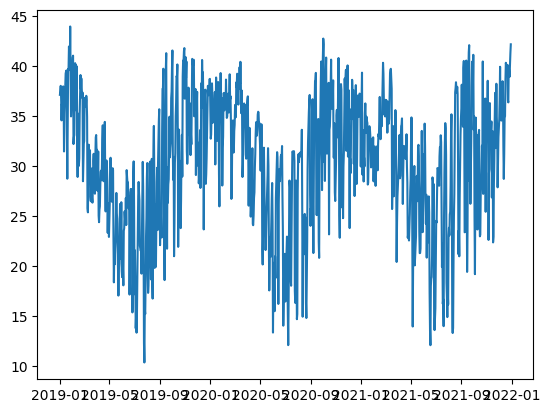

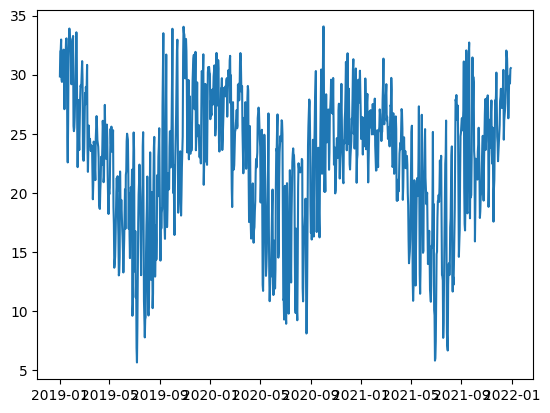

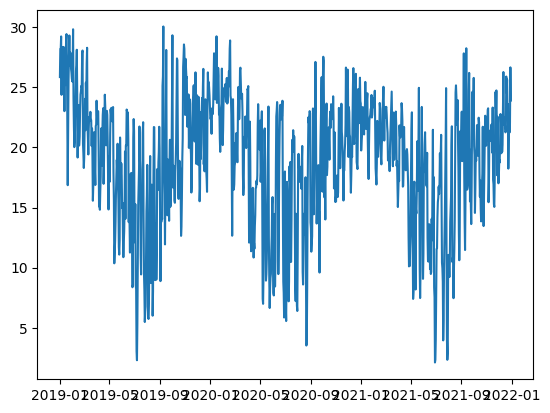

In [42]:
plt.figure(1)
plt.plot(percentiles_diarios['Percentil_95'])
plt.figure(2)
plt.plot(percentiles_diarios['Mediana'])
plt.figure(3)
plt.plot(percentiles_diarios['Percentil_5'])

# Modelo

In [75]:
# Dividir datos en conjuntos de entrenamiento y validación
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_escalado, y, test_size=0.2, random_state=SEED, shuffle=False)

mejor_num_capas =  3
training_epochs = 60

# Definir función objetivo para Optuna
def objetivo(trial):
    num_capas = mejor_num_capas
    tf.keras.utils.set_random_seed(SEED)

    #num_capas = 1
    num_unidades = trial.suggest_categorical('num_unidades', [16, 32, 64])


    # Definir la arquitectura del modelo
    modelo = Sequential()
    modelo.add(Dense(num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
    for _ in range(num_capas - 1):
        modelo.add(Dense(num_unidades, activation='relu'))

    # Capa de salida para predecir los 3 percentiles (95, 50, 5)
    modelo.add(Dense(3, activation='linear'))

    # Compilar el modelo
    modelo.compile(optimizer=Adam(),
                   loss='mse',  # Para regresión, se usa 'mean squared error'
                   metrics=['mae'])  # Mean Absolute Error (MAE) para evaluación

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=training_epochs, batch_size=256, verbose=0, shuffle=False)

    # Evaluar el modelo en el conjunto de validación
    _, val_mae = modelo.evaluate(X_validacion, y_validacion, verbose=0)

    return val_mae

# Realizar la optimización de hiperparámetros usando Optuna
estudio = optuna.create_study(direction='minimize')  # Minimizamos el MAE en lugar de maximizar
estudio.optimize(objetivo, n_trials=10)

# Obtener los mejores hiperparámetros

mejor_num_unidades = estudio.best_params['num_unidades']

print("Mejores Hiperparámetros:")
print("Número de Capas:", mejor_num_capas)
print("Número de Unidades:", mejor_num_unidades)




[I 2024-09-11 21:32:22,452] A new study created in memory with name: no-name-0f1d7204-ce6e-43a6-a0d6-a87251f50167
[I 2024-09-11 21:32:28,782] Trial 0 finished with value: 4.315955638885498 and parameters: {'num_unidades': 32}. Best is trial 0 with value: 4.315955638885498.
[I 2024-09-11 21:32:33,844] Trial 1 finished with value: 4.315955638885498 and parameters: {'num_unidades': 32}. Best is trial 0 with value: 4.315955638885498.
[I 2024-09-11 21:32:40,252] Trial 2 finished with value: 6.587668418884277 and parameters: {'num_unidades': 16}. Best is trial 0 with value: 4.315955638885498.
[I 2024-09-11 21:32:45,578] Trial 3 finished with value: 4.315955638885498 and parameters: {'num_unidades': 32}. Best is trial 0 with value: 4.315955638885498.
[I 2024-09-11 21:32:52,193] Trial 4 finished with value: 4.315955638885498 and parameters: {'num_unidades': 32}. Best is trial 0 with value: 4.315955638885498.
[I 2024-09-11 21:32:58,519] Trial 5 finished with value: 4.315955638885498 and paramet

Mejores Hiperparámetros:
Número de Capas: 3
Número de Unidades: 64


# Entrenar

In [76]:

# Entrenar el modelo final usando los mejores hiperparámetros
modelo_final = Sequential()
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))
modelo_final.add(Dense(3, activation='linear'))

modelo_final.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='mse',
                     metrics=['mae'])

# Entrenar el modelo final
history = modelo_final.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=training_epochs, batch_size=256, verbose=1, shuffle=False)

# Evaluar en conjunto de prueba
mae = modelo_final.evaluate(X_validacion, y_validacion, verbose=0)
print(f'MAE en validación: {mae}')

Epoch 1/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 632.5250 - mae: 24.0284 - val_loss: 586.6208 - val_mae: 22.8278
Epoch 2/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 625.3324 - mae: 23.8702 - val_loss: 579.2220 - val_mae: 22.6450
Epoch 3/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 617.2361 - mae: 23.6879 - val_loss: 569.8111 - val_mae: 22.4115
Epoch 4/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 606.6354 - mae: 23.4486 - val_loss: 557.1583 - val_mae: 22.1001
Epoch 5/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 592.2175 - mae: 23.1211 - val_loss: 540.3759 - val_mae: 21.6875
Epoch 6/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 572.9886 - mae: 22.6774 - val_loss: 518.4843 - val_mae: 21.1379
Epoch 7/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 547.8399 - mae: 22.0830 - val_loss: 490.2037 - val_mae: 20.4045
Epoch 8/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 515.3024 - mae: 21.2960 - val_loss: 454.2096 - val_mae: 19.4421
Epoch 9/60
4/4 ━━━━━━━━━━━━━━━━━

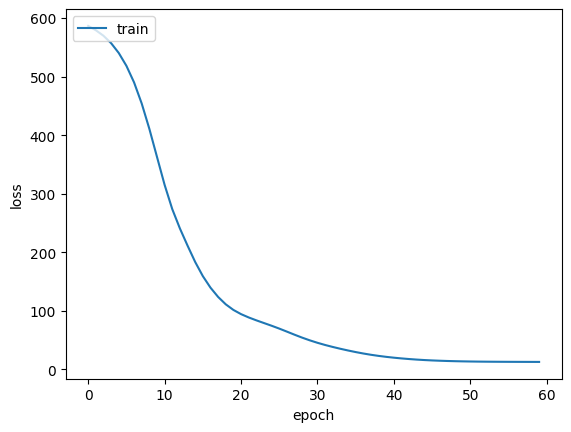

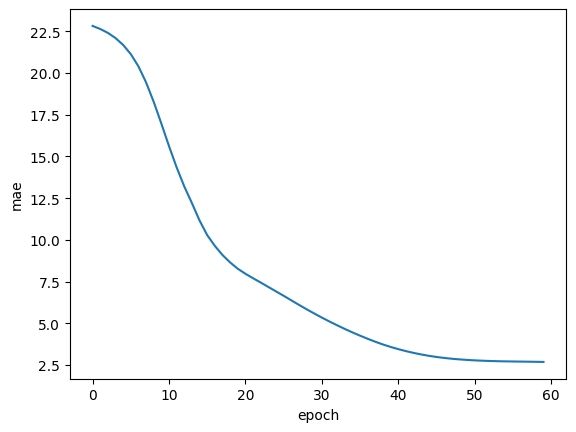

In [77]:


plt.figure()
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure()
plt.plot(history.history['val_mae'])
plt.ylabel('mae')
plt.xlabel('epoch')

plt.show()

